# 206A Final Project: Evaluating Bus Rapid Transit Routes in Los Angeles and Atlanta Using a Transit Equity/Propensity Index (Andrew Jarnagin & Aziz Fellague)

## Import Data Sources, Clean, and Organize for Analysis
American Community Survey (ACS) data on race/ethnicity, means of transportation to work, population density, poverty index, and nativity. Longitudinal Employer-Household Dynamics Origin-Destination Employment Statistics (LODES) for employment density. MARTA's More MARTA plan for BRT routes in Atlanta (except for the Capitol Avenue line, we chose stop locations because they have not yet been determined). LA Metro for Orange and Silver Line stops.

In [1]:
#import all required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx
from functools import reduce
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import plotly.express as px
from scipy.stats import ttest_ind

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#import data sources

#demographic variables
race = gpd.read_file('data/BG_B03002_race.geojson')
mode = gpd.read_file('data/BG_B08301_mode.geojson')
pop_dens = pd.read_csv('data/pop_dens.csv')
poverty = pd.read_csv('data/PovertyRatio.csv')
nativity = gpd.read_file('data/Tract_B05012_nativity.geojson')
LODES = pd.read_csv('data/ga_ca_wac_S000_JT00_2018_xtrimmed.csv')

#BRT stop data
ATL_BRT = gpd.read_file('midterm_data/MARTA_BRT_routes_stops.geojson')
LA_BRT = gpd.read_file('midterm_data/brt.geojson')

#empty gdfs that will store isochrones for each route
Cap_Ave_service = gpd.GeoDataFrame()
North_Ave_service = gpd.GeoDataFrame()
Northside_Dr_service = gpd.GeoDataFrame()
Silver_service = gpd.GeoDataFrame()
Orange_service = gpd.GeoDataFrame()

#drop all census columns w/'Error' in the title
census = [race, mode, pop_dens, poverty]
for df in census:
    df.drop(df.filter(regex='Error').columns, axis=1, inplace=True)

### Clean and Merge ACS Data (block groups)

In [3]:
#trim and rename race table
columnstokeep = ['geoid',
 'name',
 'B03002001',
 'B03002002',
 'B03002003',
 'B03002004',
 'B03002005',
 'B03002006',
 'B03002007',
 'B03002008',
 'B03002009',
 'B03002012',
 'geometry']
race = race[columnstokeep]
race.columns = ['geoid',
 'name',
 'Total',
 'Not Latinx',
 'White',
 'Black',
 'American Indian/Alaska Native',
 'Asian',
 'Native Hawaiian/Other Pacific Islander',
 'Other',
 'Two or more races',
 'Latinx',
 'geometry']
race['Percent Not Latinx'] = race['Not Latinx']/race['Total']*100
race['Percent Latinx'] = race['Latinx']/race['Total']*100
race['Percent White'] = race['White']/race['Total']*100
race['Percent Black'] = race['Black']/race['Total']*100
race['Percent American Indian/Alaska Native'] = race['American Indian/Alaska Native']/race['Total']*100
race['Percent Asian'] = race['Asian']/race['Total']*100
race['Percent Native Hawaiian/Other Pacific Islander'] = race['Native Hawaiian/Other Pacific Islander']/race['Total']*100
race['Percent Other'] = race['Other']/race['Total']*100
race['Percent Two or more races'] = race['Two or more races']/race['Total']*100
race['Percent Not Latinx White'] = 100 - race['Percent White']

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [4]:
#trim and rename mode table
columnstokeep = ['geoid',
 'B08301001',
 'B08301002',
 'B08301003',
 'B08301004',
 'B08301005',
 'B08301006',
 'B08301007',
 'B08301008',
 'B08301009',
 'B08301010',
 'B08301011',
 'B08301012',
 'B08301013',
 'B08301014',
 'B08301015',
 'B08301016',
 'B08301017',
 'B08301018',
 'B08301019',
 'B08301020',
 'B08301021']
mode = mode[columnstokeep]
mode.columns = ['geoid',
 'Total',
 'Car, truck, or van',
 'Drove alone',
 'Carpooled',
 'In 2-person carpool',
 'In 3-person carpool',
 'In 4-person carpool',
 'In 5- or 6-person carpool',
 'In 7-or-more-person carpool',
 'Public transportation (excluding taxicab)',
 'Bus',
 'Subway or elevated rail',
 'Long-distance train or commuter rail',
 'Light rail, streetcar or trolley', 
 'Ferryboat',
 'Taxicab',
 'Motorcycle',
 'Bicycle',
 'Walked',
 'Other means',
 'Worked from home']
mode['Percent Driving'] = mode['Car, truck, or van']/mode['Total']*100
mode['Percent Public Transit'] = mode['Public transportation (excluding taxicab)']/mode['Total']*100
mode['Percent Biking'] = mode['Bicycle']/mode['Total']*100
mode['Percent Walking'] = mode['Walked']/mode['Total']*100
mode['Percent Not Driving'] = 100 - mode['Percent Driving']

<ipython-input-4-88e2ab144581>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mode['Percent Driving'] = mode['Car, truck, or van']/mode['Total']*100


In [5]:
#merge ACS tables and remove duplicates
census = [race, mode, pop_dens, poverty]
census_merged = reduce(lambda  left,right: pd.merge(left,right,on=['geoid'],
                                            how='outer', suffixes=('', '_y')), census)
census_merged.drop(census_merged.filter(regex='_y$'),axis=1, inplace=True)
census_merged = gpd.GeoDataFrame(census_merged, geometry='geometry')
pd.set_option('display.max_columns', 100)
census_merged.head()

geoid                            name   Total  Not Latinx  \
0  15000US060371011101  Block Group 1, Los Angeles, CA  1688.0      1208.0   
1  15000US060371011102  Block Group 2, Los Angeles, CA  1614.0      1069.0   
2  15000US060371011103  Block Group 3, Los Angeles, CA   981.0       818.0   
3  15000US060371011221  Block Group 1, Los Angeles, CA  2156.0      2044.0   
4  15000US060371011222  Block Group 2, Los Angeles, CA  1249.0      1214.0   

    White  Black  American Indian/Alaska Native  Asian  \
0  1068.0    8.0                            0.0   44.0   
1   841.0   11.0                            3.0  179.0   
2   707.0    0.0                            0.0  108.0   
3  1812.0   74.0                           15.0  100.0   
4  1070.0    0.0                            0.0  120.0   

   Native Hawaiian/Other Pacific Islander  Other  Two or more races  Latinx  \
0                                     0.0    0.0               88.0   480.0   
1                                     3.0    8.0               24.0   545.0   
2                                     0.0    0.0                3.0   163.0   
3                                     0.0    0.0               43.0   112.0   
4                                     0.0    0.0               24.0    35.0   

                                            geometry  Percent Not Latinx  \
0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...           71.563981   
1  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...           66.232962   
2  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...           83.384302   
3  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...           94.805195   
4  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...           97.197758   

   Percent Latinx  Percent White  Percent Black  \
0       28.436019      63.270142       0.473934   
1       33.767038      52.106568       0.681537   
2       16.615698      72.069317       0.000000   
3        5.194805      84.044527       3.432282   
4        2.802242      85.668535       0.000000   

   Percent American Indian/Alaska Native  Percent Asian  \
0                               0.000000       2.606635   
1                               0.185874      11.090458   
2                               0.000000      11.009174   
3                               0.695733       4.638219   
4                               0.000000       9.607686   

   Percent Native Hawaiian/Other Pacific Islander  Percent Other  \
0                                        0.000000       0.000000   
1                                        0.185874       0.495663   
2                                        0.000000       0.000000   
3                                        0.000000       0.000000   
4                                        0.000000       0.000000   

   Percent Two or more races  Percent Not Latinx White  Car, truck, or van  \
0                   5.213270                 36.729858               584.0   
1                   1.486989                 47.893432               762.0   
2                   0.305810                 27.930683               514.0   
3                   1.994434                 15.955473              1022.0   
4                   1.921537                 14.331465               708.0   

   Drove alone  Carpooled  In 2-person carpool  In 3-person carpool  \
0        561.0       23.0                 11.0                 12.0   
1        663.0       99.0                 69.0                 30.0   
2        432.0       82.0                 71.0                 11.0   
3        918.0      104.0                 48.0                 35.0   
4        699.0        9.0                  9.0                  0.0   

   In 4-person carpool  In 5- or 6-person carpool  \
0                  0.0                        0.0   
1                  0.0                        0.0   
2                  0.0                        0.0   
3                 21.0                        0.0   
4                  0.0             

### Adjust Nativity Data
ACS data for nativity (whether an individual's place of birth was inside or outside of the U.S.) is only provided at the tract level. In an imperfect solution, we apply the tract-level percentages of U.S. and foreign-born residents to all block groups within each respective tract.

In [6]:
#new column in census_merged tract ID (existing FIPS code minus block group identifier)
census_merged['tract'] = census_merged['geoid'].str[:-1]
census_merged['tract'] = census_merged['tract'].str[7:]
#trim and rename nativity table
columnstokeep = ['geoid',
 'B05012001',
 'B05012002',
 'B05012003']
nativity = nativity[columnstokeep]
nativity.columns=['tract',
                 'Total',
                 'Native',
                 'Foreign-Born']
nativity['Percent Native'] = nativity['Native']/nativity['Total']*100
nativity['Percent Foreign-Born'] = nativity['Foreign-Born']/nativity['Total']*100
columnstokeep = ['tract',
                'Percent Native',
                'Percent Foreign-Born']
nativity = nativity[columnstokeep]
nativity['tract'] = nativity['tract'].str[7:]

In [7]:
#merge % nativity w/census_merged on trimmed FIPS
census_merged = census_merged.merge(nativity, on='tract')

### Adjust Employment Data
LODES raw employment data is at the block level, so we need to sum up total employment for all blocks within each block group, assign that value to its respective block group in the main dataframe, and then calculate employment density as total jobs / land area of the block group.

In [8]:
#add leading zero to CA FIPS code
LODES['block'] = LODES['block'].apply(lambda x: '{0:0>15}'.format(x))

#create block group column
LODES['block_group'] = LODES['block'].str[:12]

#add up employment for all blocks in each block group
emp_dens = pd.DataFrame()
emp_dens['block_group'] = LODES['block_group']
emp_dens['employment'] = LODES['Total Employment']

#sum of employment for each block group
LODES_2 = emp_dens[['block_group','employment']].groupby('block_group',as_index=False).agg(['sum'])
LODES_2 = LODES_2.reset_index()
LODES_2.columns=['geoid','Total Employment']

#remove 15000US prefix from census_merged geoid to get standard FIPS code
census_merged['geoid'] = census_merged['geoid'].str[7:]

In [9]:
#merge employment data
census_merged = census_merged.merge(LODES_2, on='geoid')

#calculate employment density
census_merged['Employment Density'] = census_merged['Total Employment']/census_merged['Area (land)']

#remove duplicate columns and null values
census_merged.drop(census_merged.filter(regex='_y$'),axis=1, inplace=True)
census_merged.drop(census_merged.filter(regex='_x$'),axis=1, inplace=True)
census_merged = census_merged.dropna()
census_merged.head()

geoid                            name   Total  Not Latinx   White  \
0  060371011101  Block Group 1, Los Angeles, CA  1688.0      1208.0  1068.0   
1  060371011102  Block Group 2, Los Angeles, CA  1614.0      1069.0   841.0   
2  060371011103  Block Group 3, Los Angeles, CA   981.0       818.0   707.0   
3  060371011221  Block Group 1, Los Angeles, CA  2156.0      2044.0  1812.0   
4  060371011222  Block Group 2, Los Angeles, CA  1249.0      1214.0  1070.0   

   Black  American Indian/Alaska Native  Asian  \
0    8.0                            0.0   44.0   
1   11.0                            3.0  179.0   
2    0.0                            0.0  108.0   
3   74.0                           15.0  100.0   
4    0.0                            0.0  120.0   

   Native Hawaiian/Other Pacific Islander  Other  Two or more races  Latinx  \
0                                     0.0    0.0               88.0   480.0   
1                                     3.0    8.0               24.0   545.0   
2                                     0.0    0.0                3.0   163.0   
3                                     0.0    0.0               43.0   112.0   
4                                     0.0    0.0               24.0    35.0   

                                            geometry  Percent Not Latinx  \
0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...           71.563981   
1  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...           66.232962   
2  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...           83.384302   
3  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...           94.805195   
4  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...           97.197758   

   Percent Latinx  Percent White  Percent Black  \
0       28.436019      63.270142       0.473934   
1       33.767038      52.106568       0.681537   
2       16.615698      72.069317       0.000000   
3        5.194805      84.044527       3.432282   
4        2.802242      85.668535       0.000000   

   Percent American Indian/Alaska Native  Percent Asian  \
0                               0.000000       2.606635   
1                               0.185874      11.090458   
2                               0.000000      11.009174   
3                               0.695733       4.638219   
4                               0.000000       9.607686   

   Percent Native Hawaiian/Other Pacific Islander  Percent Other  \
0                                        0.000000       0.000000   
1                                        0.185874       0.495663   
2                                        0.000000       0.000000   
3                                        0.000000       0.000000   
4                                        0.000000       0.000000   

   Percent Two or more races  Percent Not Latinx White  Car, truck, or van  \
0                   5.213270                 36.729858               584.0   
1                   1.486989                 47.893432               762.0   
2                   0.305810                 27.930683               514.0   
3                   1.994434                 15.955473              1022.0   
4                   1.921537                 14.331465               708.0   

   Drove alone  Carpooled  In 2-person carpool  In 3-person carpool  \
0        561.0       23.0                 11.0                 12.0   
1        663.0       99.0                 69.0                 30.0   
2        432.0       82.0                 71.0                 11.0   
3        918.0      104.0                 48.0                 35.0   
4        699.0        9.0                  9.0                  0.0   

   In 4-person carpool  In 5- or 6-person carpool  \
0                  0.0                        0.0   
1                  0.0                        0.0   
2                  0.0                        0.0   
3                 21.0                        0.0   
4                  0.0                        0.0   

   In 7-or-more-

### Split Los Angeles and Atlanta Data
To avoid duplicating work, our data import and cleaning has worked on LA County and the three-county MARTA service area in metro Atlanta simultaneously. Now that we have a unified dataframe with all the key info, we need to split the data into its respective locations in order to calculate index values based on each transit operator's reference area. These separated dataframes will also allow us to do useful mapping or visualization.

In [10]:
demog_ATL = census_merged[['GA' in x for x in census_merged['name']]]
demog_LA = census_merged[['CA' in x for x in census_merged['name']]]

## Generate Transit Equity/Propensity Index
This index attempts to measures aspects of equity, transit propensity, and transit-supportive density. We borrow ideas from LA Metro's Transit Equity Score and Nelson\Nygaard's Adjusted Population Density calculations. Our methodology is not intended to be academically rigorous, given the time constraints of the quarter system. However, it does provide an indication of equity concerns and transit needs and possibilities for a given service area. We will use the results of our index calculation to measure the extent to which BRT routes in Atlanta and Los Angeles serve areas of both high transit needs and sufficient density to support transit service, as compared to the transit agency's overall service area. 

The high scores for each variable are calculated as follows:
* Race: % non-white
* Mode: % not driving
* Population Density: higher density
* Poverty Index: % below poverty line
* Nativity: % foreign-born
* Employment Density: higher density

In [11]:
locations = [demog_ATL, demog_LA]
for df in locations:
    df['race_idx'] = pd.qcut(df['Percent Not Latinx White'], 10, labels=['1','2','3','4','5','6','7','8','9','10']) 
    df['mode_idx'] = pd.qcut(df['Percent Not Driving'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
    df['pop_dens_idx'] = pd.qcut(df['Population Density'], 10, labels=['1','2','3','4','5','6','7','8','9','10']) 
    df['poverty_idx'] = pd.qcut(df['Percent Poverty Ratio < 1'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
    df['nativity_idx'] = pd.qcut(df['Percent Foreign-Born'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
    df['emp_dens_idx'] = pd.qcut(df['Employment Density'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
    df['race_idx'] = df['race_idx'].astype(int)
    df['mode_idx'] = df['mode_idx'].astype(int)
    df['pop_dens_idx'] = df['pop_dens_idx'].astype(int)
    df['poverty_idx'] = df['poverty_idx'].astype(int)
    df['nativity_idx'] = df['nativity_idx'].astype(int)
    df['emp_dens_idx'] = df['emp_dens_idx'].astype(int)
    df['Score'] = df['race_idx'] + df['mode_idx'] + df['pop_dens_idx'] + df['poverty_idx'] + df['nativity_idx'] + df['emp_dens_idx']
    df['score_idx'] = pd.qcut(df['Score'], 10, labels=['1','2','3','4','5','6','7','8','9','10']) 
    df['score_idx'] = df['score_idx'].astype(int)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [12]:
demog_ATL.head()

geoid                        name   Total  Not Latinx  White  \
6409  130630402021  Block Group 1, Clayton, GA  1586.0      1562.0   73.0   
6410  130630402022  Block Group 2, Clayton, GA  1264.0      1079.0   65.0   
6411  130630402032  Block Group 2, Clayton, GA  3172.0      3155.0   60.0   
6412  130630402041  Block Group 1, Clayton, GA  1910.0      1758.0   42.0   
6413  130630402042  Block Group 2, Clayton, GA  1045.0       960.0   37.0   

       Black  American Indian/Alaska Native  Asian  \
6409  1404.0                            0.0   38.0   
6410   863.0                            0.0  114.0   
6411  3007.0                            0.0   59.0   
6412  1702.0                            0.0    0.0   
6413   910.0                            0.0    0.0   

      Native Hawaiian/Other Pacific Islander  Other  Two or more races  \
6409                                     0.0    0.0               47.0   
6410                                     0.0   14.0               23.0   
6411                                     0.0    0.0               29.0   
6412                                     0.0    0.0               14.0   
6413                                     0.0    0.0               13.0   

      Latinx                                           geometry  \
6409    24.0  MULTIPOLYGON (((-84.43595 33.60814, -84.42944 ...   
6410   185.0  MULTIPOLYGON (((-84.43852 33.61711, -84.43849 ...   
6411    17.0  MULTIPOLYGON (((-84.45852 33.61325, -84.45852 ...   
6412   152.0  MULTIPOLYGON (((-84.44313 33.59414, -84.44311 ...   
6413    85.0  MULTIPOLYGON (((-84.44988 33.61649, -84.44988 ...   

      Percent Not Latinx  Percent Latinx  Percent White  Percent Black  \
6409           98.486759        1.513241       4.602774      88.524590   
6410           85.363924       14.636076       5.142405      68.275316   
6411           99.464061        0.535939       1.891551      94.798235   
6412           92.041885        7.958115       2.198953      89.109948   
6413           91.866029        8.133971       3.540670      87.081340   

      Percent American Indian/Alaska Native  Percent Asian  \
6409                                    0.0       2.395965   
6410                                    0.0       9.018987   
6411                                    0.0       1.860025   
6412                                    0.0       0.000000   
6413                                    0.0       0.000000   

      Percent Native Hawaiian/Other Pacific Islander  Percent Other  \
6409                                             0.0       0.000000   
6410                                             0.0       1.107595   
6411                                             0.0       0.000000   
6412                                             0.0       0.000000   
6413                                             0.0       0.000000   

      Percent Two or more races  Percent Not Latinx White  Car, truck, or van  \
6409                   2.963430                 95.397226               572.0   
6410                   1.819620                 94.857595               479.0   
6411                   0.914250                 98.108449              1365.0   
6412                   0.732984                 97.801047               735.0   
6413                   1.244019                 96.459330               463.0   

      Drove alone  Carpooled  In 2-person carpool  In 3-person carpool  \
6409        462.0      110.0                103.0                  0.0   
6410        433.0       46.0                 35.0                 11.0   
6411       1149.0      216.0                174.0                 20.0   
6412        575.0      160.0                140.0                 20.0   
6413        463.0        0.0                  0.0                  0.0   

      In 4-person carpool  In 5- or 6-person carpool  \
6409                  0.0                        7.0   
6410                  0.0                        0.0   
6411                 22.0       

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


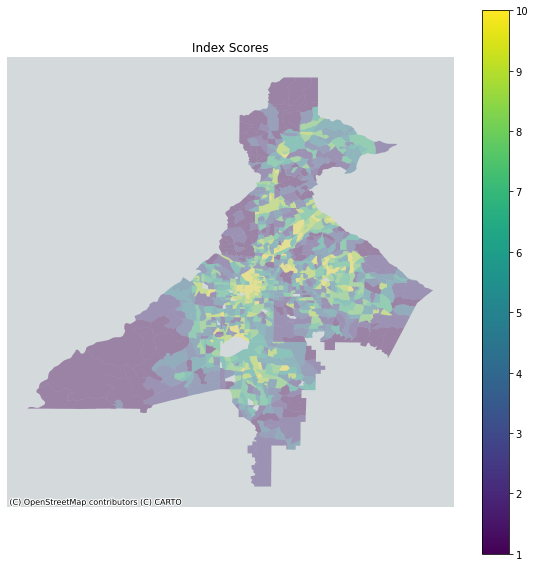

In [13]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add isochrones
demog_ATL.plot(alpha=.4,
               ax=ax,
               column='score_idx',
               cmap='viridis',
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Index Scores')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


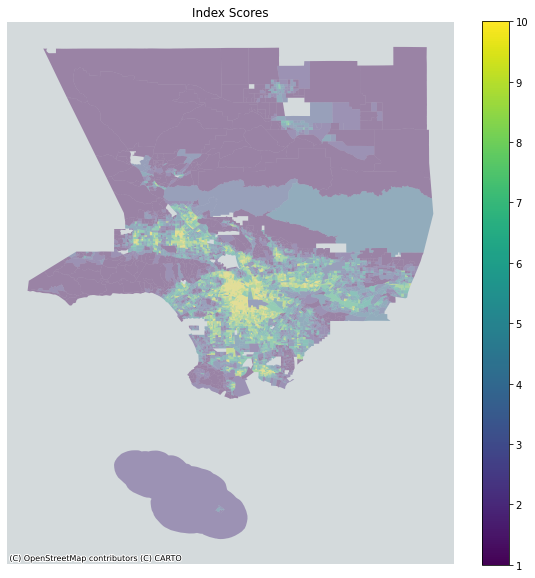

In [14]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add isochrones
demog_LA.plot(alpha=.4,
               ax=ax,
               column='score_idx',
               cmap='viridis',
               legend=True,
               zorder=20)

# no axis
ax.axis('off')

# title
ax.set_title('Index Scores')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Generate Isochrone Walksheds for BRT Stops

### Prep BRT Data

In [15]:
ATL_BRT = ATL_BRT.mask(ATL_BRT.eq('None')).dropna()
stops = [ATL_BRT]
#create 'x' and 'y' columns from geometry if they don't exist
for gdf in stops:
    if not ('lon' in gdf.columns and 'lat' in gdf.columns):
        gdf['lon'] = gdf['geometry'].x
        gdf['lat'] = gdf['geometry'].y
Cap_Ave = ATL_BRT.loc[ATL_BRT['Route'] == 'Capitol Ave BRT']
North_Ave = ATL_BRT[ATL_BRT['Route'].str.contains('North Ave', na=False)].reset_index(drop=True)
Northside_Dr = ATL_BRT[ATL_BRT['Route'].str.contains('Northside', na=False)].reset_index(drop=True)

Our Atlanta analysis examines proposed BRT routes I, J, and K from the More MARTA expansion program, seen below.

<img src="https://itsmarta.com/uploadedImages/MARTA_101/Why_MARTA/Atlanta%20Plan%20Map_LB_v4.jpg" width="800" height="800">

Routes J and K (North Ave and Northside Dr) mirror two of MARTA's most highly productive routes in the City of Atlanta (defined as more than 28 passengers per revenue hour), according to pre-pandemic ridership figures. The North Ave BRT would cover part of Route 50, while the Northside Dr BRT overlaps with a portion of Route 95.

<img src="https://pbs.twimg.com/media/EwKpLVKWYAMCvDf?format=jpg&name=large" width="800" height="800">

In [16]:
LA_BRT = LA_BRT.mask(LA_BRT.eq('None')).dropna()
stops = [LA_BRT]
#create 'x' and 'y' columns from geometry if they don't exist
for gdf in stops:
    if not ('lon' in gdf.columns and 'lat' in gdf.columns):
        gdf['lon'] = gdf['geometry'].x
        gdf['lat'] = gdf['geometry'].y

Silver = LA_BRT.loc[LA_BRT['Line'] == 'J Line'].reset_index(drop=True)
Orange = LA_BRT.loc[LA_BRT['Line'] == 'G Line'].reset_index(drop=True)

Our Los Angeles analysis examines two existing BRT lines - the Orange (G) Line in the San Fernando Valley, and the Silver (J) Line from El Monte to the South Bay via DTLA. The Orange Line opened in 2005 and the Silver Line opened in 2009.

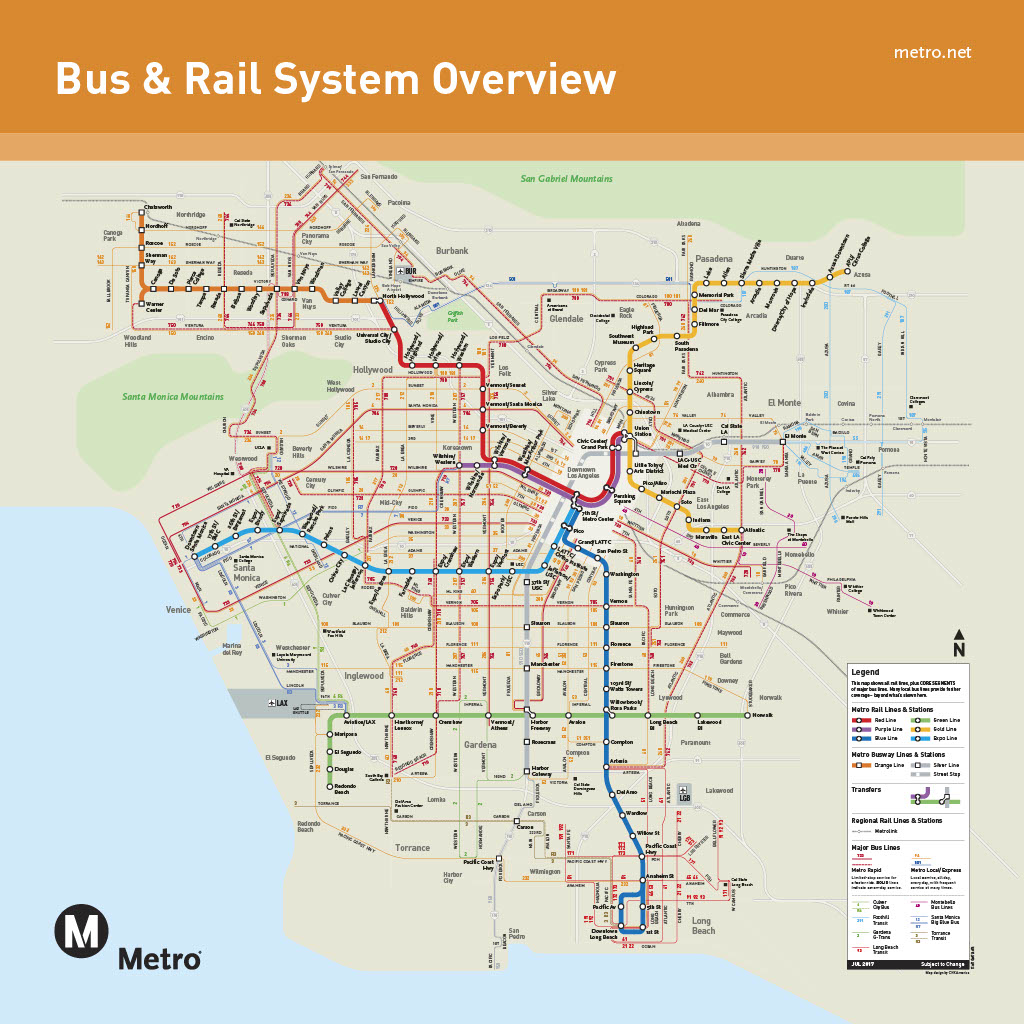

### Function to Calculate Isochrones

In [17]:
#set variables at the top so they can be easily changed as needed
network_type = 'walk'
trip_times = [10]
meters_per_minute = 75
#define the function
def isogen(gdf):
    global isochrones
    #pull relevant OSMnx data based on place variable
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #caculates center node
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
    
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    #create new gdf containing calculated isochrones
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']

In [18]:
for index,row in Cap_Ave.iterrows():
    place = row[7], row[6] 
    isogen(Cap_Ave)
    Cap_Ave_service = isochrones.append(Cap_Ave_service, ignore_index=True)

for index,row in North_Ave.iterrows():
    place = row[7], row[6] 
    isogen(North_Ave)
    North_Ave_service = isochrones.append(North_Ave_service, ignore_index=True)

for index,row in Northside_Dr.iterrows():
    place = row[7], row[6] 
    isogen(Northside_Dr)
    Northside_Dr_service = isochrones.append(Northside_Dr_service, ignore_index=True)

In [19]:
Cap_Ave_service = Cap_Ave_service.to_crs(3857)
North_Ave_service = North_Ave_service.to_crs(3857)
Northside_Dr_service = Northside_Dr_service.to_crs(3857)

In [20]:
#create gdf of isochrones for all Atlanta routes
output_ATL = Cap_Ave_service
output_ATL = North_Ave_service.append(output_ATL, ignore_index=True)
output_ATL = Northside_Dr_service.append(output_ATL, ignore_index=True)

In [21]:
#run the function for LA as well
for index,row in Silver.iterrows():
    place = row[5], row[4] 
    isogen(Silver)
    Silver_service = isochrones.append(Silver_service, ignore_index=True)
    
for index,row in Orange.iterrows():
    place = row[5], row[4] 
    isogen(Orange)
    Orange_service = isochrones.append(Orange_service, ignore_index=True)

In [22]:
Silver_service = Silver_service.to_crs(3857)
Orange_service = Orange_service.to_crs(3857)

In [23]:
#create gdf of isochrones for all LA routes
output_LA = Silver_service
output_LA = Orange_service.append(output_LA, ignore_index=True)

### Spatial join of demographic dataframe and isochrone walksheds
A series of spatial joins will allow us to analyze the demographic variables of areas served by BRT routes. First, we create new spatially joined gdf for the areas served by all BRT routes analyzed. Then, for more granular analysis, we also create spatiall joined gdfs for the areas served by each individual line. With these sets of dataframes, we can compare demographics and index scores for the BRT system as a whole and also for each line.

In [24]:
#ATLANTA
#output_ATL = output_ATL.to_crs(3857) 
demog_ATL = demog_ATL.to_crs(3857)

#we're going to perform a spatial join based on the centroid of census tracts
demog_ATL['centroid']=demog_ATL['geometry'].centroid.to_crs(epsg=3857)
demog_ATL['rep_point']=demog_ATL['geometry'].representative_point().to_crs(epsg=3857)

#set the gdf's geometry as the centroid column and spatial join
demog_ATL = gpd.GeoDataFrame(demog_ATL, geometry='centroid')
served_ATL = gpd.sjoin(demog_ATL, output_ATL, op='intersects')
served_Cap_Ave = gpd.sjoin(demog_ATL, Cap_Ave_service, op='intersects')
served_North_Ave = gpd.sjoin(demog_ATL, North_Ave_service, op='intersects')
served_Northside_Dr = gpd.sjoin(demog_ATL, Northside_Dr_service, op='intersects')

#now that we've produced the joined dataset, we can switch its geometry back to the geometry column
demog_ATL = gpd.GeoDataFrame(demog_ATL, geometry='geometry')
served_ATL = gpd.GeoDataFrame(served_ATL, geometry='geometry')
served_Cap_Ave = gpd.GeoDataFrame(served_Cap_Ave, geometry='geometry')
served_North_Ave = gpd.GeoDataFrame(served_North_Ave, geometry='geometry')
served_Northside_Dr = gpd.GeoDataFrame(served_Northside_Dr, geometry='geometry')

In [25]:
#LOS ANGELES
output_LA = output_LA.to_crs(3857) 
demog_LA = demog_LA.to_crs(3857)

#we're going to perform a spatial join based on the centroid of census tracts
demog_LA['centroid']=demog_LA['geometry'].centroid.to_crs(epsg=3857)
demog_LA['rep_point']=demog_LA['geometry'].representative_point().to_crs(epsg=3857)

#set the gdf's geometry as the centroid column and spatial join
demog_LA = gpd.GeoDataFrame(demog_LA, geometry='centroid')
served_LA = gpd.sjoin(demog_LA, output_LA, op='intersects')
served_Silver = gpd.sjoin(demog_LA, Silver_service, op='intersects')
served_Orange = gpd.sjoin(demog_LA, Orange_service, op='intersects')

#now that we've produced the joined dataset, we can switch its geometry back to the geometry column
demog_LA = gpd.GeoDataFrame(demog_LA, geometry='geometry')
served_LA = gpd.GeoDataFrame(served_LA, geometry='geometry')
served_Silver = gpd.GeoDataFrame(served_Silver, geometry='geometry')
served_Orange = gpd.GeoDataFrame(served_Orange, geometry='geometry')

## Descriptive Statistics

### General Statistics for Los Angeles & Clayton, Dekalb, and Fulton Counties

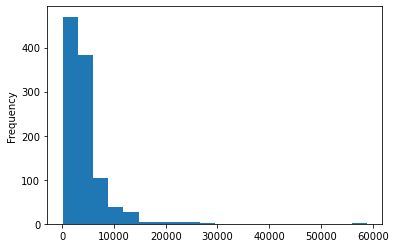

In [26]:
#histogram of population density - ATL
demog_ATL['Population Density'].plot.hist(bins=20)

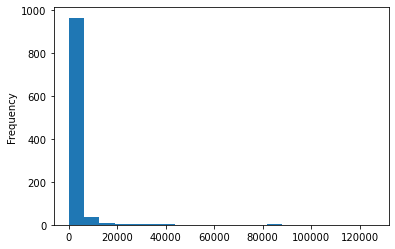

In [27]:
#histogram of employment density - ATL
demog_ATL['Employment Density'].plot.hist(bins=20)

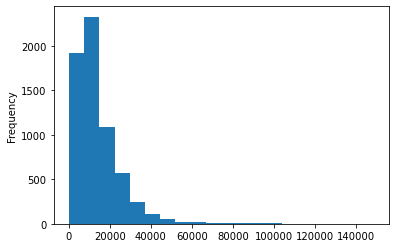

In [28]:
#histogram of population density - LA
demog_LA['Population Density'].plot.hist(bins=20)

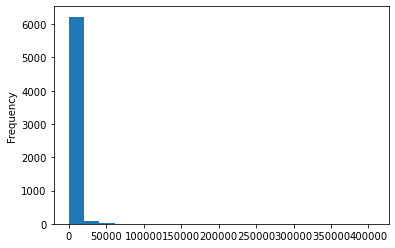

In [29]:
#histogram of employment density - LA
demog_LA['Employment Density'].plot.hist(bins=20)

### Comparative Stats for Areas Served by BRT Routes

In [30]:
#print index values of block groups served by each route, all routes for each city, and overall service area
stat_groups = [demog_ATL, served_ATL, served_Cap_Ave, served_North_Ave, served_Northside_Dr, demog_LA, served_LA, served_Silver, served_Orange]
names = ['Atlanta (Clayton, Dekalb, & Fulton Counties)', 'Atlanta BRT Service Walksheds', 'Capitol Ave BRT', 'North Ave BRT', 'Northside Dr BRT', 'Los Angeles County', 'Los Angeles BRT Service Walksheds', 'Silver Line','Orange Line']
for i, df in zip(names, stat_groups):
        print('The average index score for ' + i + ' is ' + str(df['score_idx'].mean()))

The average index score for Atlanta (Clayton, Dekalb, & Fulton Counties) is 5.3224254090471605
The average index score for Atlanta BRT Service Walksheds is 8.338709677419354
The average index score for Capitol Ave BRT is 9.083333333333334
The average index score for North Ave BRT is 7.823529411764706
The average index score for Northside Dr BRT is 8.333333333333334
The average index score for Los Angeles County is 5.388122845502977
The average index score for Los Angeles BRT Service Walksheds is 7.423841059602649
The average index score for Silver Line is 8.151515151515152
The average index score for Orange Line is 6.038461538461538


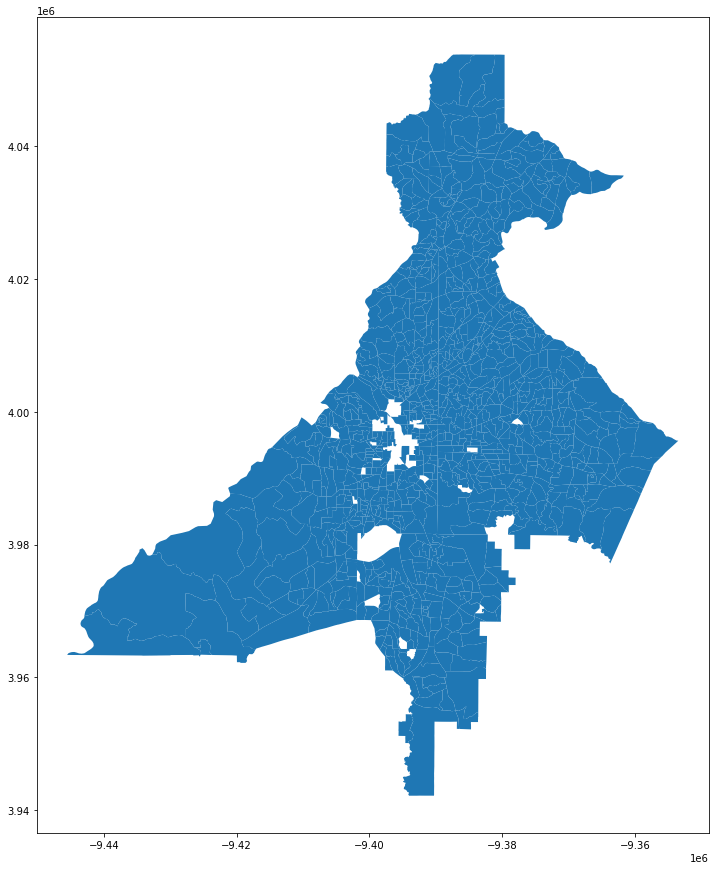

In [31]:
#create gdf of total area minus block groups served by BRT
duplicates = pd.merge(served_ATL, demog_ATL, how='inner',
                  left_on=['geoid'], right_on=['geoid'],
                  left_index=True)
notserved_ATL = demog_ATL.drop(duplicates.index)
notserved_ATL.plot(figsize=(15,15))

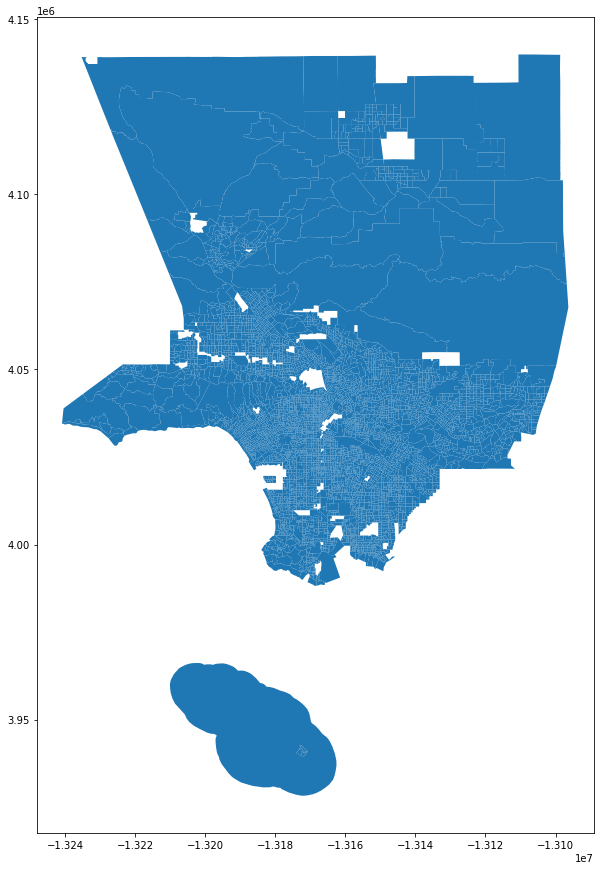

In [32]:
#create gdf of total area minus block groups served by BRT
duplicates = pd.merge(served_LA, demog_LA, how='inner',
                  left_on=['geoid'], right_on=['geoid'],
                  left_index=True)
notserved_LA = demog_LA.drop(duplicates.index)
notserved_LA.plot(figsize=(15,15))

In [33]:
stat_groups = [demog_ATL, served_ATL, demog_LA, served_LA]
names = ['Atlanta Area', 'Atlanta BRT Service Walksheds', 'Los Angeles County', 'Los Angeles BRT Service Walksheds']
for i, df in zip(names, stat_groups):
        print('The average % non-white population for ' + i + ' is ' + str(df['Percent Not Latinx White'].mean()))
        print('The average % of non-drivers for ' + i + ' is ' + str(df['Percent Not Driving'].mean()))
        print('The average % of population in poverty for ' + i + ' is ' + str(df['Percent Poverty Ratio < 1'].mean()))
        print('The average % foreign-born population for ' + i + ' is ' + str(df['Percent Foreign-Born'].mean()))
        print('The average population density per sq. mi. for ' + i + ' is ' + str(df['Population Density'].mean()))
        print('The average % employment density per sq. mi. for ' + i + ' is ' + str(df['Employment Density'].mean()))

The average % non-white population for Atlanta Area is 65.49896495150993
The average % of non-drivers for Atlanta Area is 20.42655555150462
The average % of population in poverty for Atlanta Area is 16.246929740134743
The average % foreign-born population for Atlanta Area is 13.301548059134712
The average population density per sq. mi. for Atlanta Area is 4232.953762608274
The average % employment density per sq. mi. for Atlanta Area is 2646.119504087447
The average % non-white population for Atlanta BRT Service Walksheds is 79.66901622609856
The average % of non-drivers for Atlanta BRT Service Walksheds is 33.46081884752469
The average % of population in poverty for Atlanta BRT Service Walksheds is 31.477741935483873
The average % foreign-born population for Atlanta BRT Service Walksheds is 6.347779358759117
The average population density per sq. mi. for Atlanta BRT Service Walksheds is 6566.4786290322645
The average % employment density per sq. mi. for Atlanta BRT Service Walksheds i

### Statistical Significance Test for Index Scores of Areas Served by BRT versus Rest-of-Region
The mean index scores above show an apparent difference between block groups served by BRT as compared to the rest of the county(ies) in each transit operator's service area. However, we can perform a basic statistical analysis using a t-test to determine whether these differences in mean scores are statistically significant.

Null hypothesis: There is no difference in mean index scores between areas served and not served by BRT.
Research hypothesis: There is a difference in mean index scores between areas served and not served by BRT.
Alpha level: .05

**If the t-test yields a p-value of less than the alpha level of .05, the difference in mean scores is statistically significant.**

In [34]:
#t-test on score_idx column - ATL
group1 = notserved_ATL['score_idx']
group2 = served_ATL['score_idx']

ttest_ind(group1,group2)

Ttest_indResult(statistic=-8.491064163794325, pvalue=6.771212074938322e-17)

In [35]:
#t-test on score_idx column - LA
group1 = notserved_LA['score_idx']
group2 = served_LA['score_idx']

ttest_ind(group1,group2)

Ttest_indResult(statistic=-8.676746233333553, pvalue=5.095558276521585e-18)

For both Atlanta and Los Angeles, the t-test produced a p-value of less than our alpha-level of .05. 

**We can therefore reject the null hypothesis, and we have evidence for a statistical difference in mean index scores between areas served by BRT and those not served for Atlanta and Los Angeles.**

## Spatial Statistics - Atlanta

### Global Autocorrelation

In [36]:
#Generate spatial weights using the KNN method and 8 nearest neighbors (k=8)
wq =  lps.weights.KNN.from_dataframe(demog_ATL,k=8)

wq.transform = 'r'

#Create new column of spatial lag, which factors in neighboring tracts as defined by the spatial weight method
demog_ATL['score_idx_lag'] = lps.weights.lag_spatial(wq, demog_ATL['score_idx'])
demog_ATL['score_idx_diff'] = demog_ATL['score_idx'] - demog_ATL['score_idx_lag']

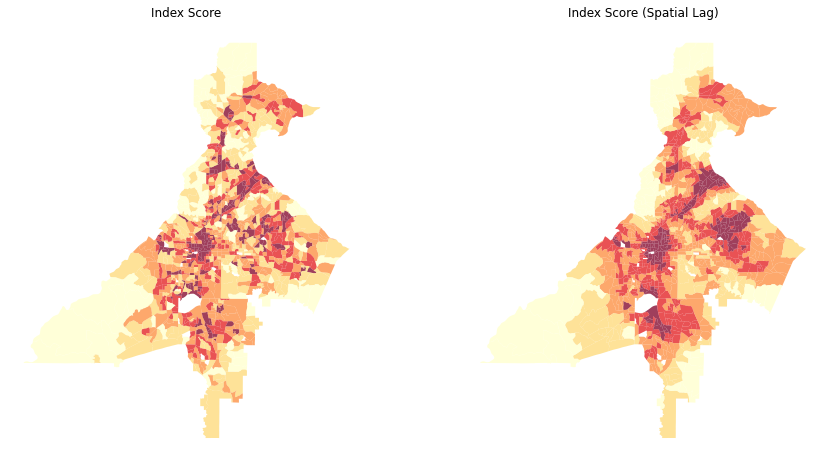

In [37]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_ATL.plot(ax=ax[0], # this assigns the map to the left subplot
         column='score_idx', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Index Score")

# spatial lag map on the right
demog_ATL.plot(ax=ax[1], # this assigns the map to the right subplot
         column='score_idx_lag', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Index Score (Spatial Lag)")

plt.show()

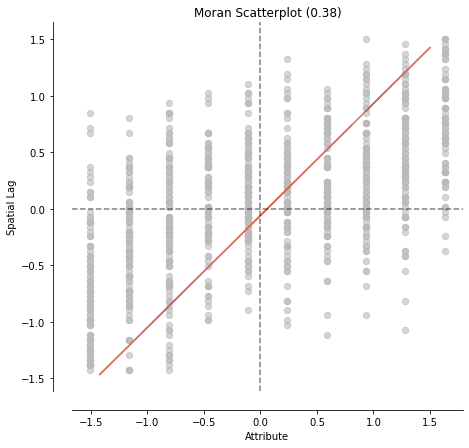

In [38]:
y = demog_ATL.score_idx
moran = Moran(y, wq)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc7f72fee0>)

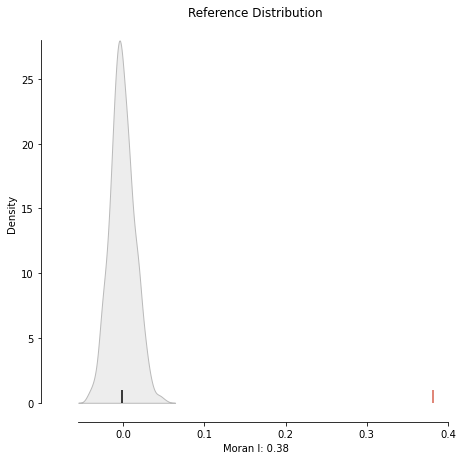

In [39]:
plot_moran_simulation(moran,aspect_equal=False)

In [40]:
moran.p_sim

0.001

### Local Indicators of Spatial Autocorrelation (LISA)

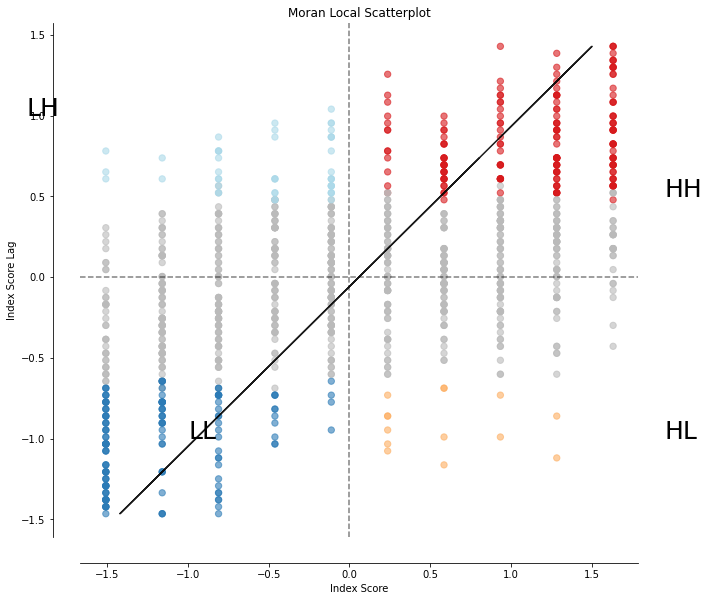

In [41]:
lisa = esda.moran.Moran_Local(y, wq)
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Index Score")
ax.set_ylabel('Index Score Lag')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

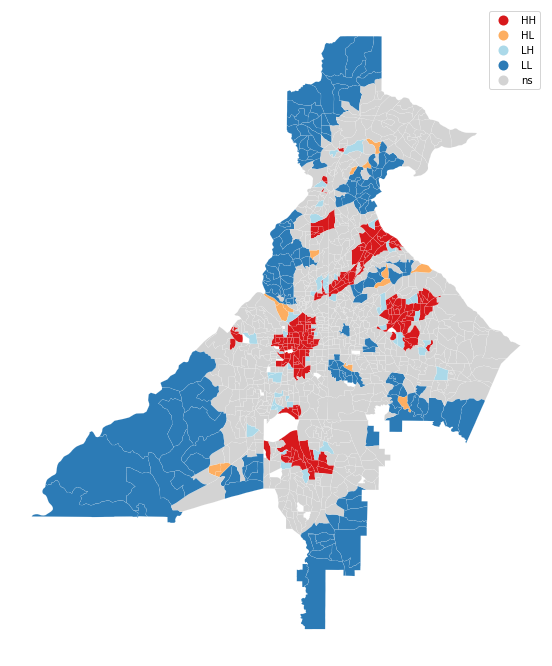

In [42]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, demog_ATL, p=0.05, ax=ax)
plt.show()

## Spatial Statistics - Los Angeles

### Global Autocorrelation

In [43]:
#Generate spatial weights using the KNN method and 8 nearest neighbors (k=8)
wq =  lps.weights.KNN.from_dataframe(demog_LA,k=8)

wq.transform = 'r'

#Create new column of spatial lag, which factors in neighboring tracts as defined by the spatial weight method
demog_LA['score_idx_lag'] = lps.weights.lag_spatial(wq, demog_LA['score_idx'])
demog_LA['score_idx_diff'] = demog_LA['score_idx'] - demog_LA['score_idx_lag']

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


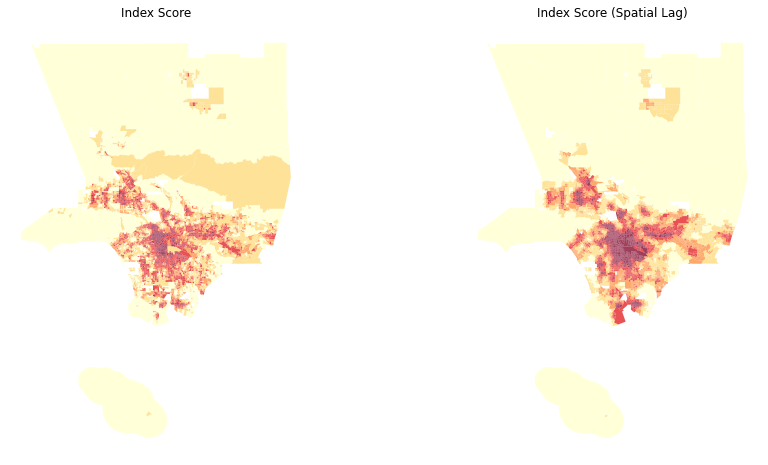

In [44]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_LA.plot(ax=ax[0], # this assigns the map to the left subplot
         column='score_idx', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Index Score")

# spatial lag map on the right
demog_LA.plot(ax=ax[1], # this assigns the map to the right subplot
         column='score_idx_lag', 
         cmap='YlOrRd', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Index Score (Spatial Lag)")

plt.show()

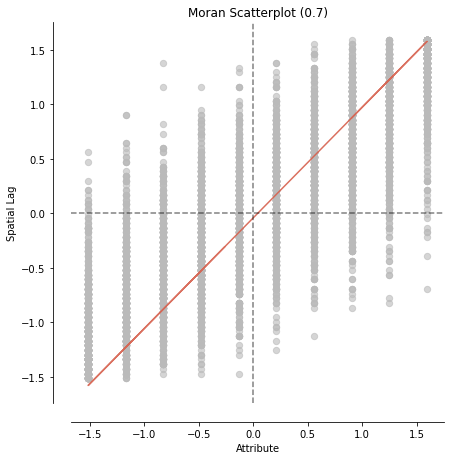

In [45]:
y = demog_LA.score_idx
moran = Moran(y, wq)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc80a3fee0>)

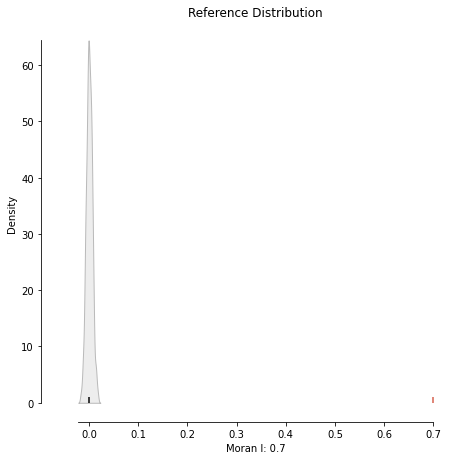

In [46]:
plot_moran_simulation(moran,aspect_equal=False)

In [47]:
moran.p_sim

0.001

### Local Indicators of Spatial Autocorrelation (LISA)

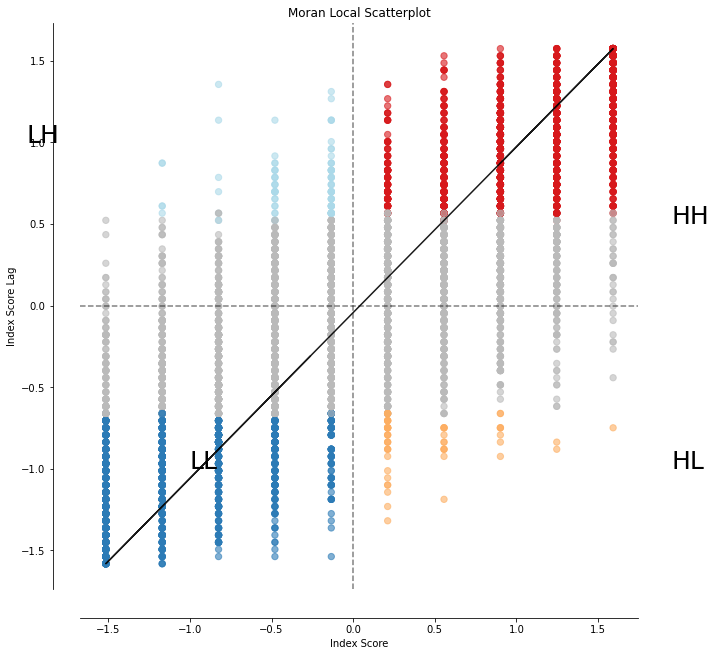

In [48]:
lisa = esda.moran.Moran_Local(y, wq)
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Index Score")
ax.set_ylabel('Index Score Lag')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

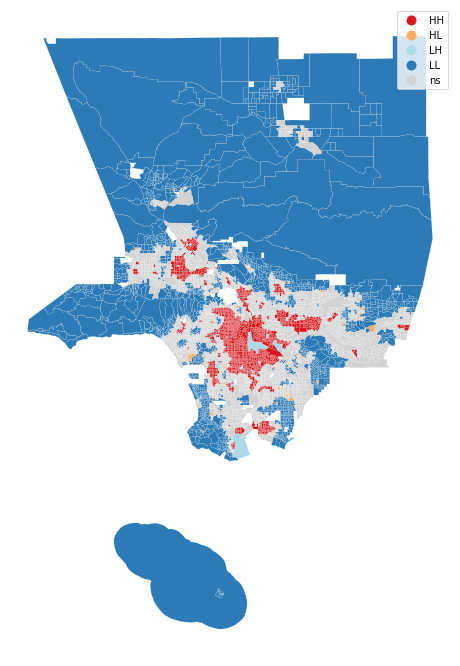

In [49]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, demog_LA, p=0.05, ax=ax)
plt.show()

## Visualizations

### Los Angeles and Atlanta Area Demographics

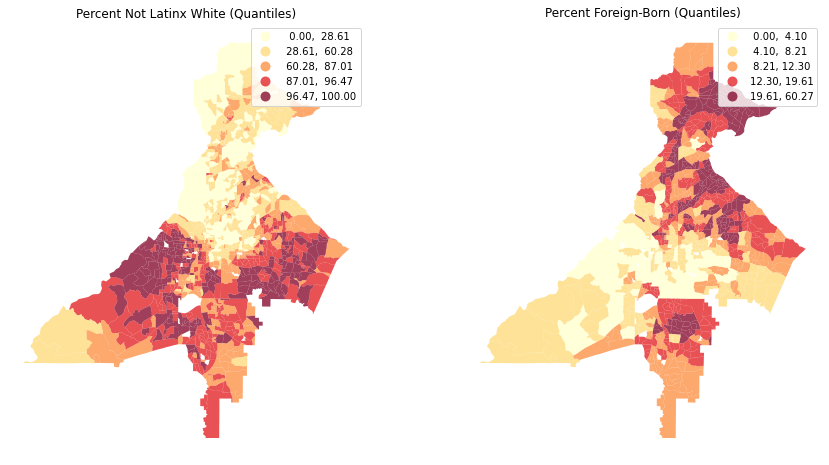

In [50]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_ATL.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Percent Not Latinx White', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Percent Not Latinx White (Quantiles)")

# spatial lag map on the right
demog_ATL.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Percent Foreign-Born', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         legend=True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Percent Foreign-Born (Quantiles)")

plt.show()

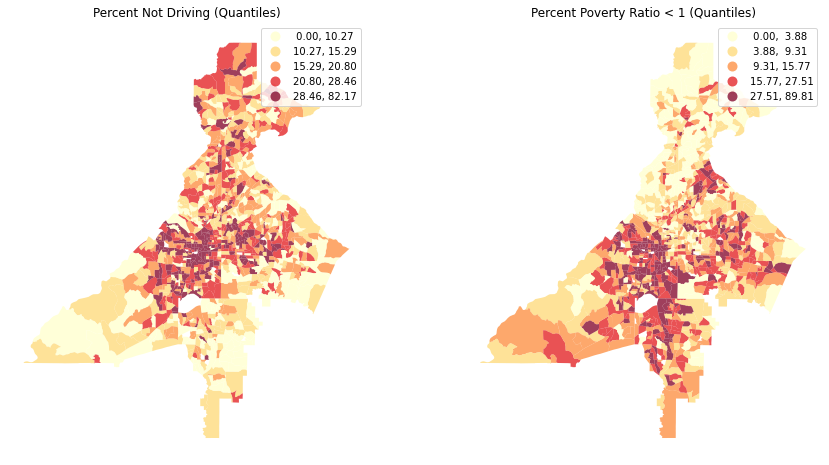

In [51]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_ATL.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Percent Not Driving', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Percent Not Driving (Quantiles)")

# spatial lag map on the right
demog_ATL.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Percent Poverty Ratio < 1', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         legend=True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Percent Poverty Ratio < 1 (Quantiles)")

plt.show()

The City of Atlanta and significant parts of Dekalb County boast many non-drivers, while poverty also extends deep into south Fulton County and eastern Dekalb.

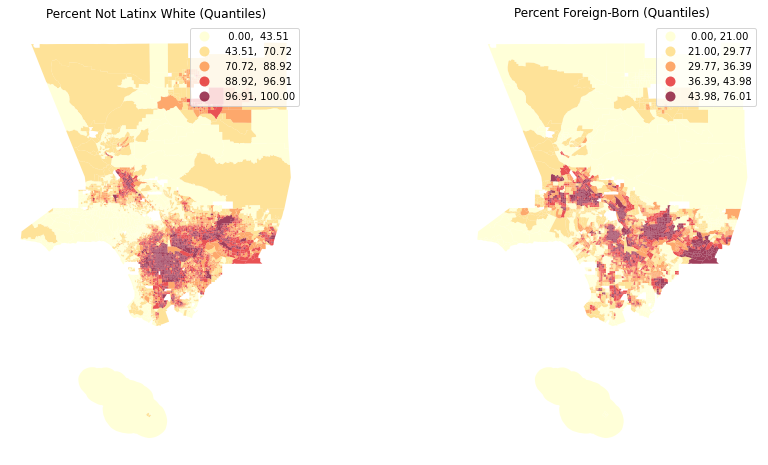

In [52]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_LA.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Percent Not Latinx White', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Percent Not Latinx White (Quantiles)")

# spatial lag map on the right
demog_LA.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Percent Foreign-Born', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         legend=True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Percent Foreign-Born (Quantiles)")

plt.show()

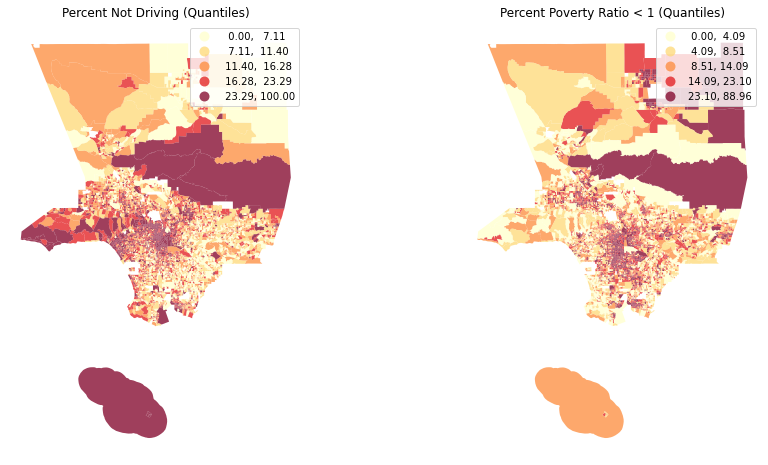

In [53]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_LA.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Percent Not Driving', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Percent Not Driving (Quantiles)")

# spatial lag map on the right
demog_LA.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Percent Poverty Ratio < 1', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         legend=True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Percent Poverty Ratio < 1 (Quantiles)")

plt.show()

Noteworthy differences in these maps include more non-drivers in the Simi Valley and West LA with little poverty, significant poverty and high automobile reliance in Lancaster and Palmdale, and more heavily concentrated non-drivers near DTLA as opposed to concentrated poverty in South LA.

### Population and Employment Densities

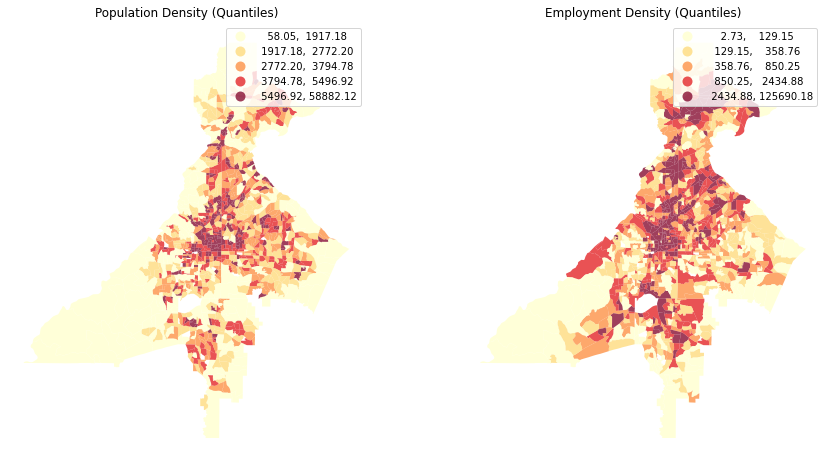

In [54]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_ATL.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Population Density', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Population Density (Quantiles)")

# spatial lag map on the right
demog_ATL.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Employment Density', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         legend=True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Employment Density (Quantiles)")

plt.show()

Population density is concentrated in central Atlanta and some along the GA-400 corridor, while employment density is more spread across the region, while notable groupings in the northern suburbs.

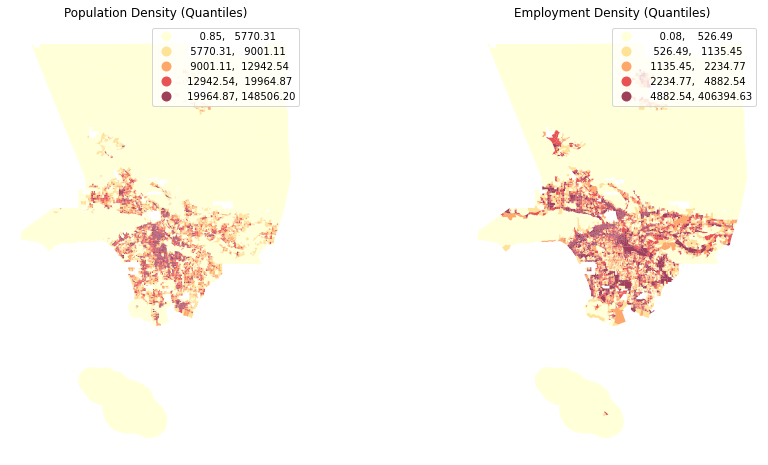

In [55]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
demog_LA.plot(ax=ax[0], # this assigns the map to the left subplot
         column='Population Density', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Population Density (Quantiles)")

# spatial lag map on the right
demog_LA.plot(ax=ax[1], # this assigns the map to the right subplot
         column='Employment Density', 
         cmap='YlOrRd', 
         scheme='quantiles',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Employment Density (Quantiles)")

plt.show()

Central areas of Los Angeles are significantly denser than the rest of the county. Jobs centers beyond Central LA include much of the Santa Monica Bay and the South Bay region, Burbank/Glendale, and scattered areas in the San Fernando and San Gabriel Valleys.

### Chloropleth Map of Index Scores for Areas Served by BRT

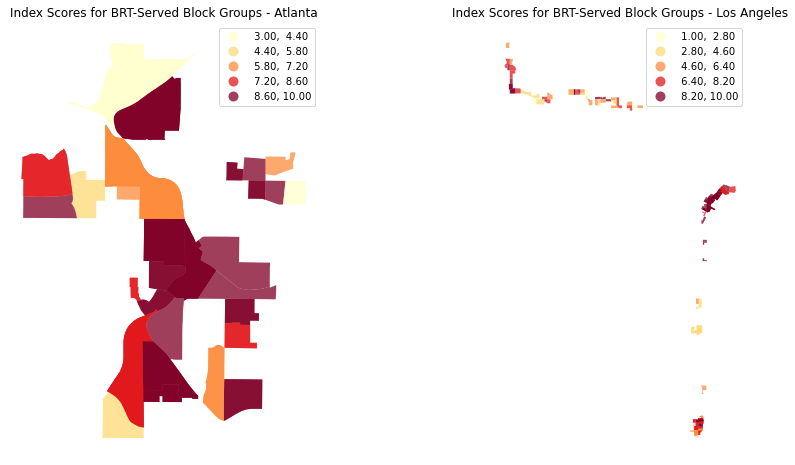

In [56]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
served_ATL.plot(ax=ax[0], # this assigns the map to the left subplot
         column='score_idx', 
         cmap='YlOrRd', 
         scheme='equal_interval',
         k=5, 
         edgecolor='white', 
         legend=True,
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Index Scores for BRT-Served Block Groups - Atlanta")

# spatial lag map on the right
served_LA.plot(ax=ax[1], # this assigns the map to the right subplot
         column='score_idx', 
         cmap='YlOrRd', 
         scheme='equal_interval',
         k=5, 
         edgecolor='white',
         legend=True,
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Index Scores for BRT-Served Block Groups - Los Angeles")

plt.show()

### Isochrone Walksheds for BRT Routes + Existing MARTA Heavy Rail Routes
Because the Atlanta BRT routes do not yet exist, we can plot the walksheds for stops of the three routes alongside existing MARTA heavy rail lines.

In [57]:
MARTA = gpd.read_file('data/5ca617a1-f700-4a63-b048-f2b854f625b72020330-1-rxyg14.qu0n9.shp')
MARTA_rail = MARTA.loc[MARTA['route_type'] == '1']
MARTA_rail['color'] = ''
MARTA_rail.loc[MARTA_rail['route_shor'] == 'GOLD', 'color'] = 'yellow'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'RED', 'color'] = 'red'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'GREEN', 'color'] = 'green'
MARTA_rail.loc[MARTA_rail['route_shor'] == 'BLUE', 'color'] = 'blue'
MARTA_rail = MARTA_rail.to_crs(epsg=3857)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


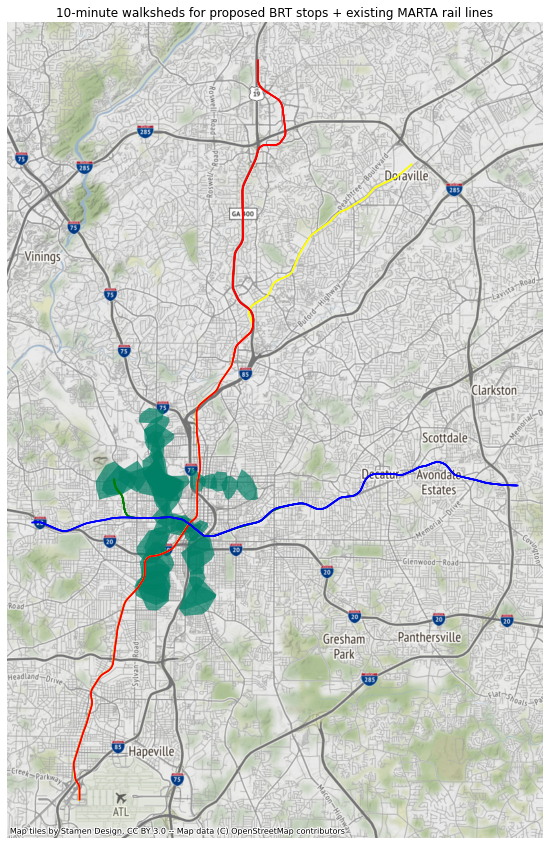

In [58]:
#MARTA base
base = MARTA_rail.plot(figsize=(15,15),color=MARTA_rail['color'])
base.axis('off')
# add isochrones
output_ATL.plot(alpha=.7,
         ax=base,
         cmap='summer',   
         column='time')

# title
base.set_title('10-minute walksheds for proposed BRT stops + existing MARTA rail lines')

# add a basemap
ctx.add_basemap(base)

* If you build BRT in Atlanta, you get a green stickman!

## Results
Our data shows that both BRT routes in Los Angeles and all three routes in Atlanta serve neighborhoods with higher transit equity/propensity scores than the region at large. We then conducted a t-test to examine the statistical significance of this finding. For both Los Angeles and Atlanta, p-values of less than .001 allow us to conclude that the differences in scores between BRT service areas and the regions at large are statistically significant. From an initial analysis, we conclude that these BRT routes are well-located to serve priority equity communities in areas of transit-supportive density.

### Average Transit Equity/Propensity Index Scores
* All block groups in Atlanta (Clayton, Dekalb, and Fulton Counties): 5.32
* Block groups served by the three proposed BRT routes in Atlanta: 8.39
* Block groups served by the Capitol Ave BRT: 9.08
* Block groups served by the North Ave BRT: 7.82
* Block groups served by the Northside Dr BRT: 8.33

* All block groups in Los Angeles County: 5.39
* Block groups served by the Silver and Orange Lines in Los Angeles: 7.42
* Block groups served by the Silver Line: 8.15
* Block groups served by the Orange Line: 6.04


### Spatial Autocorrelation
* Atlanta: islands of high scores include much of central Atlanta, the Buford Hwy Corridor, Stone Mountain, and neighborhoods near the airport.
* Los Angeles: much of Central, South, and East LA is high-high block groups, along with concentrations in the San Fernando and San Gabriel Valleys.

## Credits
Andrew led the Atlanta section; coded the isochrone function and equity/propensity index calculations; wrote the results section; and collaborated on exploring and cleaning data. Aziz led the Los Angeles section; built the StoryMap; wrote the introduction, background and methodology sections; and collaborated on exploring and cleaning data.